In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/UBC-OCEAN/train_thumbnails'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/UBC-OCEAN/train_thumbnails/52275_thumbnail.png
/kaggle/input/UBC-OCEAN/train_thumbnails/47960_thumbnail.png
/kaggle/input/UBC-OCEAN/train_thumbnails/4_thumbnail.png
/kaggle/input/UBC-OCEAN/train_thumbnails/57468_thumbnail.png
/kaggle/input/UBC-OCEAN/train_thumbnails/20316_thumbnail.png
/kaggle/input/UBC-OCEAN/train_thumbnails/27315_thumbnail.png
/kaggle/input/UBC-OCEAN/train_thumbnails/46793_thumbnail.png
/kaggle/input/UBC-OCEAN/train_thumbnails/43815_thumbnail.png
/kaggle/input/UBC-OCEAN/train_thumbnails/25792_thumbnail.png
/kaggle/input/UBC-OCEAN/train_thumbnails/48502_thumbnail.png
/kaggle/input/UBC-OCEAN/train_thumbnails/55281_thumbnail.png
/kaggle/input/UBC-OCEAN/train_thumbnails/56221_thumbnail.png
/kaggle/input/UBC-OCEAN/train_thumbnails/29147_thumbnail.png
/kaggle/input/UBC-OCEAN/train_thumbnails/43875_thumbnail.png
/kaggle/input/UBC-OCEAN/train_thumbnails/33708_thumbnail.png
/kaggle/input/UBC-OCEAN/train_thumbnails/57265_thumbnail.png
/kaggle/input/UBC-OCEAN/trai

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score , auc
from sklearn.model_selection import train_test_split

import cv2
#from google.colab.patches import cv2_imshow
from PIL import Image 
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Input, Dense,Conv2D , MaxPooling2D, Flatten,BatchNormalization,Dropout
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_hub as hub 

In [3]:
train_df = pd.read_csv("/kaggle/input/UBC-OCEAN/train.csv")
train_df

,image_id,label,image_width,image_height,is_tma
0,4,HGSC,23785,20008,False
1,66,LGSC,48871,48195,False
2,91,HGSC,3388,3388,True
3,281,LGSC,42309,15545,False
4,286,EC,37204,30020,False
...,...,...,...,...,...
533,65022,LGSC,53355,46675,False
534,65094,MC,55042,45080,False
535,65300,HGSC,75860,27503,False
536,65371,HGSC,42551,41800,False


In [4]:
train_df.nunique()

image_id        538
label             5
image_width     508
image_height    508
is_tma            2
dtype: int64

In [5]:
train_df['label'].value_counts()

label
HGSC    222
EC      124
CC       99
LGSC     47
MC       46
Name: count, dtype: int64

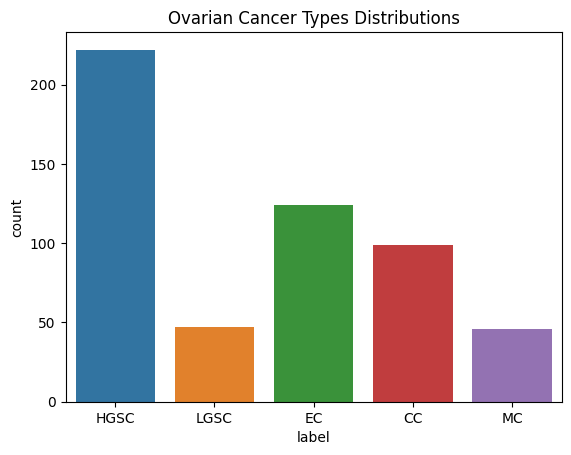

In [6]:
sns.countplot(data=train_df, x="label")
plt.title("Ovarian Cancer Types Distributions")
plt.show()

In [7]:
path_train = "/kaggle/input/UBC-OCEAN/train_thumbnails"
path_test = "/kaggle/input/UBC-OCEAN/test_thumbnails"
train_folder = os.listdir(path_train)
test_folder = os.listdir(path_test)

print(len(train_folder))
print(len(test_folder))

513
1


In [8]:
train_folder[:5]

['52275_thumbnail.png',
 '47960_thumbnail.png',
 '4_thumbnail.png',
 '57468_thumbnail.png',
 '20316_thumbnail.png']

In [9]:
test_folder

['41_thumbnail.png']

In [10]:
train_df_tma = train_df[train_df['is_tma']==True]
train_df_tma

,image_id,label,image_width,image_height,is_tma
2,91,HGSC,3388,3388,True
37,4134,MC,2964,2964,True
76,8280,HGSC,2964,2964,True
83,9200,MC,3388,3388,True
112,13568,LGSC,2964,2964,True
149,17637,HGSC,2964,2964,True
176,21020,MC,3388,3388,True
236,29084,LGSC,3388,3388,True
263,31594,EC,3388,3388,True
288,35565,MC,2964,2964,True


In [11]:
train_df_no_tma = train_df[train_df['is_tma']==False]
train_df_no_tma

,image_id,label,image_width,image_height,is_tma
0,4,HGSC,23785,20008,False
1,66,LGSC,48871,48195,False
3,281,LGSC,42309,15545,False
4,286,EC,37204,30020,False
5,431,HGSC,39991,40943,False
...,...,...,...,...,...
533,65022,LGSC,53355,46675,False
534,65094,MC,55042,45080,False
535,65300,HGSC,75860,27503,False
536,65371,HGSC,42551,41800,False


In [12]:
train_df_tma['image_id_path'] = [f"{i}.png" for i in train_df_tma['image_id']]

In [13]:
train_df_tma

,image_id,label,image_width,image_height,is_tma,image_id_path
2,91,HGSC,3388,3388,True,91.png
37,4134,MC,2964,2964,True,4134.png
76,8280,HGSC,2964,2964,True,8280.png
83,9200,MC,3388,3388,True,9200.png
112,13568,LGSC,2964,2964,True,13568.png
149,17637,HGSC,2964,2964,True,17637.png
176,21020,MC,3388,3388,True,21020.png
236,29084,LGSC,3388,3388,True,29084.png
263,31594,EC,3388,3388,True,31594.png
288,35565,MC,2964,2964,True,35565.png


In [14]:
train_df_no_tma['image_id_path'] = [f"{i}_thumbnail.png" for i in train_df_no_tma['image_id']]

In [15]:
train_df_no_tma

,image_id,label,image_width,image_height,is_tma,image_id_path
0,4,HGSC,23785,20008,False,4_thumbnail.png
1,66,LGSC,48871,48195,False,66_thumbnail.png
3,281,LGSC,42309,15545,False,281_thumbnail.png
4,286,EC,37204,30020,False,286_thumbnail.png
5,431,HGSC,39991,40943,False,431_thumbnail.png
...,...,...,...,...,...,...
533,65022,LGSC,53355,46675,False,65022_thumbnail.png
534,65094,MC,55042,45080,False,65094_thumbnail.png
535,65300,HGSC,75860,27503,False,65300_thumbnail.png
536,65371,HGSC,42551,41800,False,65371_thumbnail.png


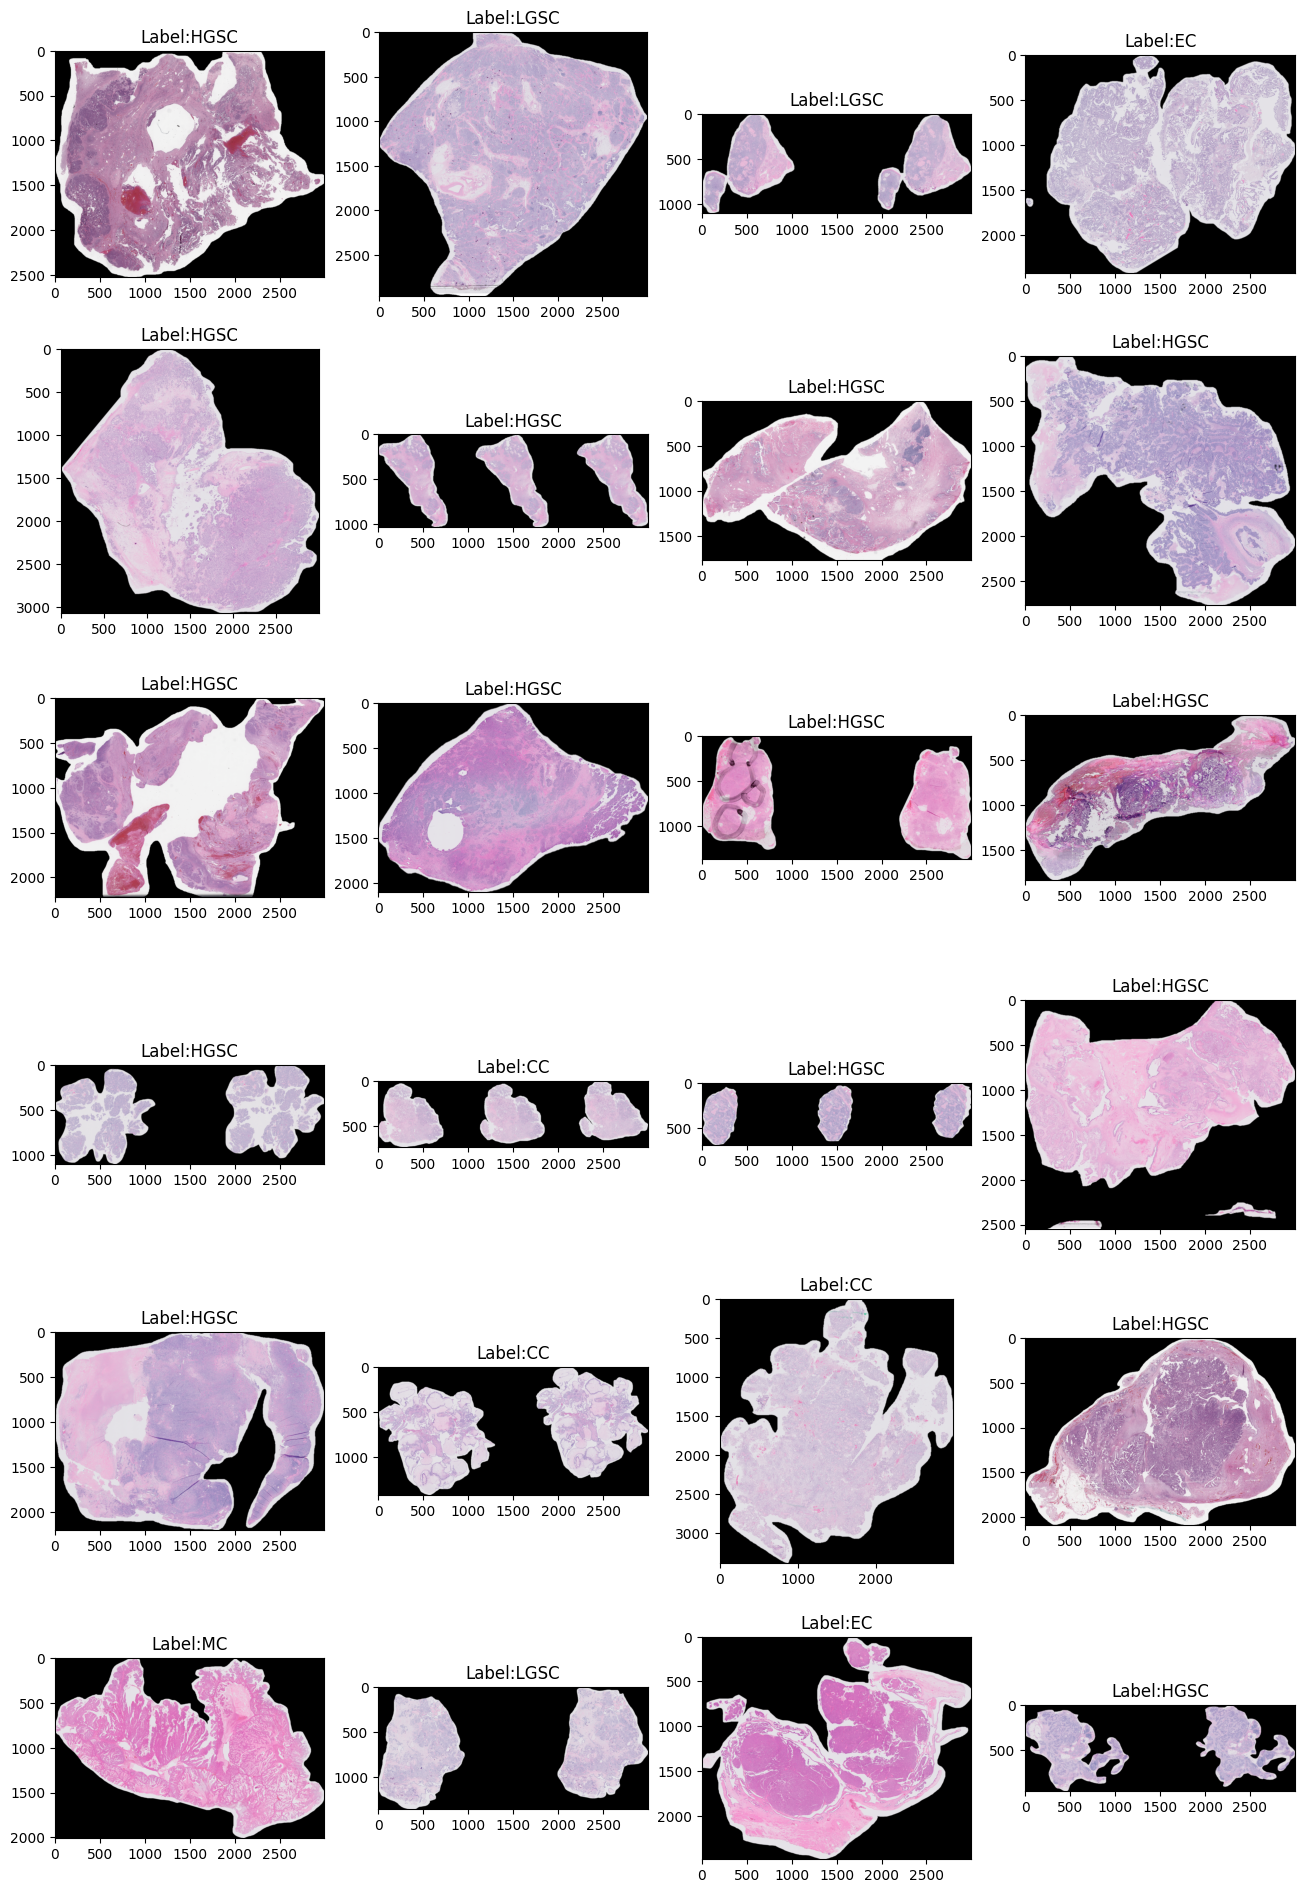

In [16]:
plt.figure(figsize=(16,24))
path = "/kaggle/input/UBC-OCEAN/train_thumbnails"
j=1
for img, lb in zip(train_df_no_tma['image_id_path'][:24],train_df_no_tma['label'][:24]):
    plt.subplot(6,4,j)
    path = os.path.join("/kaggle/input/UBC-OCEAN/train_thumbnails/",img)
    image = plt.imread(path)
    image = plt.imshow(image)
    plt.title(f"Label:{lb}")
    j+=1

# Start try Extract Patches for one image

In [17]:
train_folder[0]

'52275_thumbnail.png'

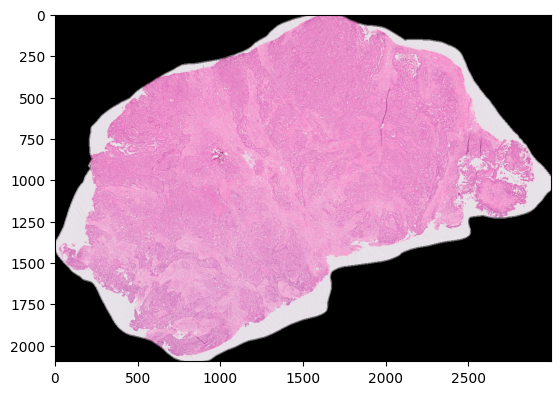

In [18]:
first_image_path = "/kaggle/input/UBC-OCEAN/train_thumbnails/" + train_folder[0]
first_image = plt.imread(first_image_path)
plt.imshow(first_image)

In [19]:
first_image = tf.io.read_file(first_image_path)
first_image = tf.image.decode_jpeg(first_image, channels=3)

first_image_tensor = tf.convert_to_tensor(first_image)


patch_height = 100
patch_width = 100

first_image_patch = tf.image.extract_patches([first_image_tensor], 
                                             sizes = [1, patch_height, patch_width, 1], 
                                             strides=[1, patch_height, patch_width, 1], 
                                             rates=[1, 1, 1, 1], 
                                             padding='VALID')
first_image_patch

<tf.Tensor: shape=(1, 20, 30, 30000), dtype=uint8, numpy=
array([[[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        ...,

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0

In [20]:
print(first_image.shape)
print(first_image_patch.shape)

(2095, 3000, 3)
(1, 20, 30, 30000)


In [21]:
first_image_patch[0][0].shape

TensorShape([30, 30000])

# Try With Patches

In [22]:
!pip install patchify

In [23]:
import patchify
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [24]:
IMG = cv2.imread("/kaggle/input/UBC-OCEAN/train_thumbnails/" + train_folder[0])
IMG = cv2.cvtColor(IMG, cv2.COLOR_BGR2RGB)

In [25]:
IMG.size # (width, height)

18855000

In [26]:
from albumentations.pytorch import ToTensorV2
import albumentations as A

transform = A.Compose(
            [
                A.Resize(512, 512),
#                 A.ShiftScaleRotate(
#                     shift_limit=0.1, scale_limit=0.15, rotate_limit=60, p=0.5
#                 ),
#                 A.HueSaturationValue(
#                     hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5
#                 ),
#                 A.RandomBrightnessContrast(
#                     brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5
#                 ),
#                 A.Normalize(
#                     mean=[0.485, 0.456, 0.406],
#                     std=[0.229, 0.224, 0.225],
#                     max_pixel_value=255.0,
#                     p=1.0,
#                 ),
#                 ToTensorV2(),
            ],
            p=1,
        )

In [27]:
# numpy_array = np.array(IMG)
image = transform(image=IMG)["image"]

In [28]:
image.shape

(512, 512, 3)

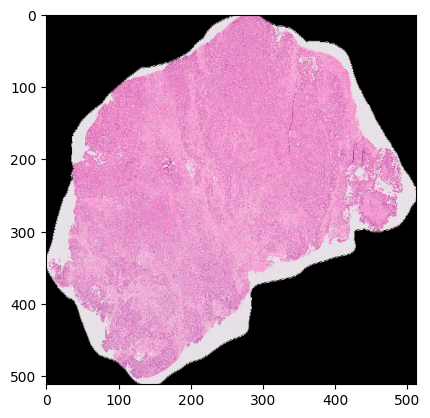

In [29]:
plt.imshow(image)

In [30]:
gather = []

patches = patchify.patchify(np.asarray(image), patch_size=(32, 32, 3), step=32)

In [31]:
patches.shape

(16, 16, 1, 32, 32, 3)

In [32]:
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        get_patches = patches[i, j, 0, :, :, :]
        gather.append(get_patches)

In [33]:
len(gather)

256

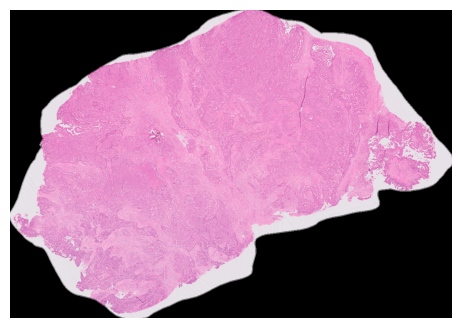

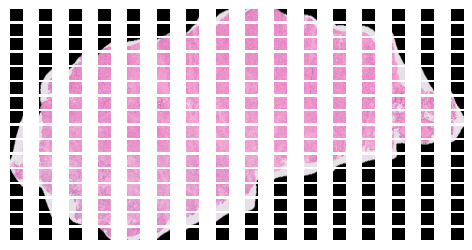

In [34]:
plt.figure(figsize=(6, 4))
plt.imshow(IMG)
plt.axis('off')

fig1, ax1 = plt.subplots(nrows=16, ncols=16, figsize=(6, 3))

a = 0
for R1 in range(16):
    for C1 in range(16):
        ax1[R1, C1].imshow(gather[a])
        ax1[R1, C1].axis('off')
        a += 1

In [35]:
print(gather[0].shape)

(32, 32, 3)


In [36]:
sum(sum(sum(gather[0])))

0

In [37]:
sum(sum(sum(gather[200])))

213

In [38]:
patches_not_black = []

for i in gather:
    if sum(sum(sum(i))) != 0:
        patches_not_black.append(i)

print(len(patches_not_black))

187


In [39]:
sum(sum(sum(patches_not_black[10])))

575

# Start try Extract Patches For All Training Data

In [40]:
train_df['image_id_path'] = [f"{i}_thumbnail.png" for i in train_df['image_id']]
train_df

,image_id,label,image_width,image_height,is_tma,image_id_path
0,4,HGSC,23785,20008,False,4_thumbnail.png
1,66,LGSC,48871,48195,False,66_thumbnail.png
2,91,HGSC,3388,3388,True,91_thumbnail.png
3,281,LGSC,42309,15545,False,281_thumbnail.png
4,286,EC,37204,30020,False,286_thumbnail.png
...,...,...,...,...,...,...
533,65022,LGSC,53355,46675,False,65022_thumbnail.png
534,65094,MC,55042,45080,False,65094_thumbnail.png
535,65300,HGSC,75860,27503,False,65300_thumbnail.png
536,65371,HGSC,42551,41800,False,65371_thumbnail.png


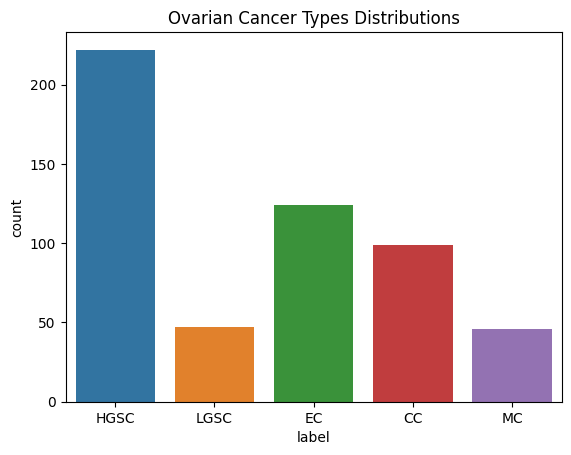

In [41]:
sns.countplot(data=train_df, x="label")
plt.title("Ovarian Cancer Types Distributions")
plt.show()

In [42]:
from albumentations.pytorch import ToTensorV2
import albumentations as A


training_patches_hgsc = []
training_patches_lgsc = []
training_patches_ec = []
training_patches_cc = []
training_patches_mc = []
other = []
count = 0


transform = A.Compose(
            [
                A.Resize(512, 512),
                A.ShiftScaleRotate(
                    shift_limit=0.1, scale_limit=0.15, rotate_limit=60, p=0.5
                ),
                A.HueSaturationValue(
                    hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5
                ),
                A.RandomBrightnessContrast(
                    brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5
                ),
                A.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                    max_pixel_value=255.0,
                    p=1.0,
                ),
                ToTensorV2(),
            ],
            p=1,
        )

for i in train_df["image_id_path"]:   
    try:
        IMG = cv2.imread("/kaggle/input/UBC-OCEAN/train_thumbnails/" + i)
        IMG = cv2.cvtColor(IMG, cv2.COLOR_BGR2RGB)
#         IMG = Image.open("/kaggle/input/UBC-OCEAN/train_thumbnails/" + i)
# FileNotFoundError
    except:
        print(f"File not found: {i}")
        count += 1
        continue
    ###########################
    gather = []

    patches = patchify.patchify(np.asarray(IMG), patch_size=(32, 32, 3), step=32)
    ###########################
    for j in range(patches.shape[0]):
        for k in range(patches.shape[1]):
            get_patches = patches[j, k, 0, :, :, :]
            gather.append(get_patches)
    ###########################
        
    if (train_df.loc[train_df['image_id_path'] == f"{i}", 'label'][count]) == "HGSC":
        for j in gather:
            if sum(sum(sum(j))) != 0:
                training_patches_hgsc.append(j)
        gather[:] = []
        
    elif (train_df.loc[train_df['image_id_path'] == f"{i}", 'label'][count]) == "LGSC":
        for j in gather:
            if sum(sum(sum(j))) != 0:
                training_patches_lgsc.append(j)   
        gather[:] = []
                
    elif (train_df.loc[train_df['image_id_path'] == f"{i}", 'label'][count]) == "EC":
        for j in gather:
            if sum(sum(sum(j))) != 0:
                training_patches_ec.append(j)   
        gather[:] = []
                
    elif (train_df.loc[train_df['image_id_path'] == f"{i}", 'label'][count]) == "CC":
        for j in gather:
            if sum(sum(sum(j))) != 0:
                training_patches_cc.append(j)
        gather[:] = []
                
    elif (train_df.loc[train_df['image_id_path'] == f"{i}", 'label'][count]) == "MC":
        for j in gather:
            if sum(sum(sum(j))) != 0:
                training_patches_mc.append(j)
        gather[:] = []
        
    else: 
        print("hoba", i)
        print("ho", gather)
        for j in gather:
            if sum(sum(sum(j))) != 0:
                other.append(j)
        gather[:] = []
    
    count += 1
    

# image = transform(image=IMG)["image"]
print("hgsc", len(training_patches_hgsc))
print("lgsc", len(training_patches_lgsc))
print("ec", len(training_patches_ec))
print("cc", len(training_patches_cc))
print("mc", len(training_patches_mc))
print("other", len(other))

[ WARN:0@346.421] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/UBC-OCEAN/train_thumbnails/91_thumbnail.png'): can't open/read file: check file path/integrity


File not found: 91_thumbnail.png


[ WARN:0@367.300] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/UBC-OCEAN/train_thumbnails/4134_thumbnail.png'): can't open/read file: check file path/integrity


File not found: 4134_thumbnail.png


[ WARN:0@396.633] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/UBC-OCEAN/train_thumbnails/8280_thumbnail.png'): can't open/read file: check file path/integrity


File not found: 8280_thumbnail.png


[ WARN:0@400.979] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/UBC-OCEAN/train_thumbnails/9200_thumbnail.png'): can't open/read file: check file path/integrity


File not found: 9200_thumbnail.png


[ WARN:0@421.937] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/UBC-OCEAN/train_thumbnails/13568_thumbnail.png'): can't open/read file: check file path/integrity


File not found: 13568_thumbnail.png


[ WARN:0@444.246] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/UBC-OCEAN/train_thumbnails/17637_thumbnail.png'): can't open/read file: check file path/integrity


File not found: 17637_thumbnail.png


[ WARN:0@462.585] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/UBC-OCEAN/train_thumbnails/21020_thumbnail.png'): can't open/read file: check file path/integrity


File not found: 21020_thumbnail.png


[ WARN:0@503.448] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/UBC-OCEAN/train_thumbnails/29084_thumbnail.png'): can't open/read file: check file path/integrity


File not found: 29084_thumbnail.png


[ WARN:0@519.671] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/UBC-OCEAN/train_thumbnails/31594_thumbnail.png'): can't open/read file: check file path/integrity


File not found: 31594_thumbnail.png


[ WARN:0@539.117] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/UBC-OCEAN/train_thumbnails/35565_thumbnail.png'): can't open/read file: check file path/integrity


File not found: 35565_thumbnail.png


[ WARN:0@545.634] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/UBC-OCEAN/train_thumbnails/36302_thumbnail.png'): can't open/read file: check file path/integrity


File not found: 36302_thumbnail.png


[ WARN:0@547.127] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/UBC-OCEAN/train_thumbnails/36583_thumbnail.png'): can't open/read file: check file path/integrity


File not found: 36583_thumbnail.png


[ WARN:0@548.565] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/UBC-OCEAN/train_thumbnails/36783_thumbnail.png'): can't open/read file: check file path/integrity


File not found: 36783_thumbnail.png


[ WARN:0@550.736] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/UBC-OCEAN/train_thumbnails/37385_thumbnail.png'): can't open/read file: check file path/integrity


File not found: 37385_thumbnail.png


[ WARN:0@577.750] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/UBC-OCEAN/train_thumbnails/40864_thumbnail.png'): can't open/read file: check file path/integrity


File not found: 40864_thumbnail.png


[ WARN:0@579.674] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/UBC-OCEAN/train_thumbnails/41368_thumbnail.png'): can't open/read file: check file path/integrity
[ WARN:0@579.675] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/UBC-OCEAN/train_thumbnails/41586_thumbnail.png'): can't open/read file: check file path/integrity


File not found: 41368_thumbnail.png
File not found: 41586_thumbnail.png


[ WARN:0@583.574] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/UBC-OCEAN/train_thumbnails/42857_thumbnail.png'): can't open/read file: check file path/integrity


File not found: 42857_thumbnail.png


[ WARN:0@593.024] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/UBC-OCEAN/train_thumbnails/44603_thumbnail.png'): can't open/read file: check file path/integrity


File not found: 44603_thumbnail.png


[ WARN:0@607.329] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/UBC-OCEAN/train_thumbnails/47035_thumbnail.png'): can't open/read file: check file path/integrity


File not found: 47035_thumbnail.png
File not found: 48734_thumbnail.png


[ WARN:0@614.218] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/UBC-OCEAN/train_thumbnails/48734_thumbnail.png'): can't open/read file: check file path/integrity
[ WARN:0@622.398] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/UBC-OCEAN/train_thumbnails/50932_thumbnail.png'): can't open/read file: check file path/integrity


File not found: 50932_thumbnail.png


[ WARN:0@643.034] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/UBC-OCEAN/train_thumbnails/53655_thumbnail.png'): can't open/read file: check file path/integrity


File not found: 53655_thumbnail.png


[ WARN:0@664.781] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/UBC-OCEAN/train_thumbnails/57696_thumbnail.png'): can't open/read file: check file path/integrity


File not found: 57696_thumbnail.png
File not found: 61797_thumbnail.png


[ WARN:0@681.703] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/UBC-OCEAN/train_thumbnails/61797_thumbnail.png'): can't open/read file: check file path/integrity


hgsc 789751
lgsc 146448
ec 460454
cc 333764
mc 172817
other 0


In [43]:
# print("hgsc", len(training_patches_hgsc))
# print("lgsc", len(training_patches_lgsc))
# print("ec", len(training_patches_ec))
# print("cc", len(training_patches_cc))
# print("mc", len(training_patches_mc))
# print("other", len(other))
type(training_patches_hgsc[0].shape)

tuple

# Try With Transformer

In [44]:
columns = ['original_image_path', 'order', 'label']
df = pd.DataFrame(columns=columns)
df

,original_image_path,order,label


In [45]:
df.loc[len(df)] = [1, 2, 5]
df

,original_image_path,order,label
0,1,2,5


In [46]:
df = df.drop(df.index)

In [47]:
df

,original_image_path,order,label


In [ ]:
# import albumentations as A
# transform = A.Compose(
#             [
#                 A.Resize(512, 512),
#                 A.ShiftScaleRotate(
#                     shift_limit=0.1, scale_limit=0.15, rotate_limit=60, p=0.5
#                 ),
#                 A.HueSaturationValue(
#                     hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5
#                 ),
#                 A.RandomBrightnessContrast(
#                     brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5
#                 ),
#             ])

In [ ]:
training_patches_hgsc = []
training_patches_lgsc = []
training_patches_ec = []
training_patches_cc = []
training_patches_mc = []
other = []

training_patches_hgsc_temp = []
training_patches_lgsc_temp = []
training_patches_ec_temp = []
training_patches_cc_temp = []
training_patches_mc_temp = []

count = 0

folder_path = os.path.join('/kaggle/working/', 'patch_images')
for i in train_df["image_id_path"]:
    try:
        IMG = Image.open("/kaggle/input/UBC-OCEAN/train_thumbnails/" + i)
        IMG = np.array(IMG)
        IMG = cv2.resize(IMG, (512, 512))
        
    except FileNotFoundError:
        print(f"File not found: {i}")
        count += 1
        continue
    ###########################
    gather = []

    patches = patchify.patchify(np.asarray(IMG), patch_size=(32, 32, 3), step=32)
    ###########################
    for j in range(patches.shape[0]):
        for k in range(patches.shape[1]):
            get_patches = patches[j, k, 0, :, :, :]
            gather.append(get_patches)
    ###########################
    
    if (train_df.loc[train_df['image_id_path'] == f"{i}", 'label'][count]) == "HGSC":
        for j in gather:
            if sum(sum(sum(j))) != 0:
                training_patches_hgsc.append(j)
                training_patches_hgsc_temp.append(j)
        for indexo, patch in enumerate(training_patches_hgsc_temp):
            df.loc[len(df)] = [i, indexo, (train_df.loc[train_df['image_id_path'] == f"{i}", 'label'][count])]
            # Creating an image from the NumPy array
            img = Image.fromarray(patch)

            # Specify the path where you want to save the image in your working folder
            patch_path = f"{indexo}" + "_" + i
            img_path = os.path.join(folder_path, patch_path)

            # Save the image to the working folder
            img.save(img_path)
            
        gather[:] = []
        training_patches_hgsc_temp[:] = []
        
    elif (train_df.loc[train_df['image_id_path'] == f"{i}", 'label'][count]) == "LGSC":
        for j in gather:
            if sum(sum(sum(j))) != 0:
                training_patches_lgsc.append(j)
                training_patches_lgsc_temp.append(j)
        for indexo, patch in enumerate(training_patches_lgsc_temp):
            df.loc[len(df)] = [i, indexo, (train_df.loc[train_df['image_id_path'] == f"{i}", 'label'][count])]
            # Creating an image from the NumPy array
            img = Image.fromarray(patch)

            # Specify the path where you want to save the image in your working folder
            patch_path = f"{indexo}" + "_" + i
            img_path = os.path.join(folder_path, patch_path)

            # Save the image to the working folder
            img.save(img_path)
            
        gather[:] = []
        training_patches_lgsc_temp[:] = []
                
    elif (train_df.loc[train_df['image_id_path'] == f"{i}", 'label'][count]) == "EC":
        for j in gather:
            if sum(sum(sum(j))) != 0:
                training_patches_ec.append(j) 
                training_patches_ec_temp.append(j)
        for indexo, patch in enumerate(training_patches_ec_temp):
            df.loc[len(df)] = [i, indexo, (train_df.loc[train_df['image_id_path'] == f"{i}", 'label'][count])]
            # Creating an image from the NumPy array
            img = Image.fromarray(patch)

            # Specify the path where you want to save the image in your working folder
            patch_path = f"{indexo}" + "_" + i
            img_path = os.path.join(folder_path, patch_path)

            # Save the image to the working folder
            img.save(img_path)
            
        gather[:] = []
        training_patches_ec_temp[:] = []
                
    elif (train_df.loc[train_df['image_id_path'] == f"{i}", 'label'][count]) == "CC":
        for j in gather:
            if sum(sum(sum(j))) != 0:
                training_patches_cc.append(j)
                training_patches_cc_temp.append(j)
        for indexo, patch in enumerate(training_patches_cc_temp):
            df.loc[len(df)] = [i, indexo, (train_df.loc[train_df['image_id_path'] == f"{i}", 'label'][count])]
            # Creating an image from the NumPy array
            img = Image.fromarray(patch)

            # Specify the path where you want to save the image in your working folder
            patch_path = f"{indexo}" + "_" + i
            img_path = os.path.join(folder_path, patch_path)

            # Save the image to the working folder
            img.save(img_path)
            
        gather[:] = []
        training_patches_cc_temp[:] = []
                
    elif (train_df.loc[train_df['image_id_path'] == f"{i}", 'label'][count]) == "MC":
        for j in gather:
            if sum(sum(sum(j))) != 0:
                training_patches_mc.append(j)
                training_patches_mc_temp.append(j)
        for indexo, patch in enumerate(training_patches_mc_temp):
            df.loc[len(df)] = [i, indexo, (train_df.loc[train_df['image_id_path'] == f"{i}", 'label'][count])]
            # Creating an image from the NumPy array
            img = Image.fromarray(patch)

            # Specify the path where you want to save the image in your working folder
            patch_path = f"{indexo}" + "_" + i
            img_path = os.path.join(folder_path, patch_path)

            # Save the image to the working folder
            img.save(img_path)
            
        gather[:] = []
        training_patches_mc_temp[:] = []
        
    else: 
        print("hoba", i)
        print("ho", gather)
        for j in gather:
            if sum(sum(sum(j))) != 0:
                other.append(j)
        gather[:] = []
    
    count += 1
    print(df)
    
print("hgsc", len(training_patches_hgsc))
print("lgsc", len(training_patches_lgsc))
print("ec", len(training_patches_ec))
print("cc", len(training_patches_cc))
print("mc", len(training_patches_mc))
print("other", len(other))

In [ ]:
import pandas as pd

#create DataFrame
df = pd.DataFrame({'points': [10, 12, 12, 14, 13, 18],
                   'rebounds': [7, 7, 8, 13, 7, 4],
                   'assists': [11, 8, 10, 6, 6, 5]})


#add new row to end of DataFrame
df.loc[len(df.index)] = [20, 7, 5]

#view updated DataFrame
df

In [86]:
import shutil

# Specify the folder name you want to zip
folder_name = 'patch_images'

# Specify the path to the folder
folder_path = '/kaggle/working/' + folder_name

# Specify the path for the zip file
zip_file_path = '/kaggle/working/' + folder_name + "hoba" + '.zip'

# Create a zip file of the folder
shutil.make_archive(zip_file_path, 'zip', folder_path)


'/kaggle/working/patch_imageshoba.zip.zip'

In [87]:
from IPython.display import FileLink

# Provide a download link for the zip file
FileLink(rf'{zip_file_path}.zip')


/kaggle/working/patch_imageshoba.zip.zip

In [ ]:
import os

# # Specify the folder name
# folder_name = 'my_working_folder'

# # Create the working folder in Kaggle
# working_directory = '/kaggle/working/'
# folder_path = os.path.join(working_directory, folder_name)

# # Create the folder if it doesn't exist
# os.makedirs(folder_path, exist_ok=True)

# # Now, you can save files to this folder
# # Example: Creating a NumPy array (replace this with your array)
# array_data = np.random.randint(0, 255, size=(256, 256, 3), dtype=np.uint8)

# Creating an image from the NumPy array
image = Image.fromarray(array_data)

# Specify the path where you want to save the image in your working folder
image_path = os.path.join(folder_path, 'output_image.png')

# Save the image to the working folder
image.save(image_path)

# Optional: Display the saved image path
print(f"Image saved to: {image_path}")


In [84]:
import os

# Specify the folder name
folder_name = 'patch_images'

# Create the working folder in Kaggle
working_directory = '/kaggle/working/'
folder_path = os.path.join(working_directory, folder_name)



# Create the folder if it doesn't exist
os.makedirs(folder_path, exist_ok=True)

# Now, you can save files to this folder
# Example: Creating a NumPy array (replace this with your array)
array_data = np.random.randint(0, 255, size=(256, 256, 3), dtype=np.uint8)

# Creating an image from the NumPy array
image = Image.fromarray(array_data)

# Specify the path where you want to save the image in your working folder
image_path = os.path.join(folder_path, 'output_image.png')

# Save the image to the working folder
image.save(image_path)

# Optional: Display the saved image path
print(f"Image saved to: {image_path}")


Image saved to: /kaggle/working/patch_images/output_image.png


# For Local

In [91]:
#====================================== Imports ===========================================
import numpy as np 
import pandas as pd 
import os
import patchify
from PIL import Image
import matplotlib.pyplot as plt

#===================================== Variables ==========================================
training_patches_hgsc = []
training_patches_lgsc = []
training_patches_ec = []
training_patches_cc = []
training_patches_mc = []
other = []

training_patches_hgsc_temp = []
training_patches_lgsc_temp = []
training_patches_ec_temp = []
training_patches_cc_temp = []
training_patches_mc_temp = []

count = 0

#==================================== Original DF =========================================
train_df = pd.read_csv("/kaggle/input/UBC-OCEAN/train.csv")
train_df['image_id_path'] = [f"{i}_thumbnail.png" for i in train_df['image_id']]
train_df

#======================================= Main =============================================
#****************** Local Path Where You Want To Save Patches Images IN *******************
# Specify the folder path on your local machine
local_folder_path = 'https://drive.google.com/drive/folders/1ppEJE1iL256MZWvd447z-Z_7PU-9O3Op/'

# Make sure the folder exists, create it if it doesn't
os.makedirs(local_folder_path, exist_ok=True)

#************************************** Read Images ***************************************
for i in train_df["image_id_path"]:
    try:
        IMG = Image.open("/kaggle/input/UBC-OCEAN/train_thumbnails/" + i)
        IMG = np.array(IMG)
        IMG = cv2.resize(IMG, (512, 512))
        
    except FileNotFoundError:
        print(f"File not found: {i}")
        count += 1
        continue
        
    #********************************* Patchify Images ***********************************
    gather = []

    patches = patchify.patchify(np.asarray(IMG), patch_size=(32, 32, 3), step=32)
    
    for j in range(patches.shape[0]):
        for k in range(patches.shape[1]):
            get_patches = patches[j, k, 0, :, :, :]
            gather.append(get_patches)
            
    #******************************** Class Conditions **********************************
    #----------------------------------- HGSC Class ----------------------------------
    if (train_df.loc[train_df['image_id_path'] == f"{i}", 'label'][count]) == "HGSC":
        for j in gather:
            if sum(sum(sum(j))) != 0:
                training_patches_hgsc.append(j)
                training_patches_hgsc_temp.append(j)
        for indexo, patch in enumerate(training_patches_hgsc_temp):
            df.loc[len(df)] = [i, indexo, (train_df.loc[train_df['image_id_path'] == f"{i}", 'label'][count])]
            # Creating an image from the NumPy array
            img = Image.fromarray(patch)

            # Specify the path where you want to save the image in your working folder
            patch_path = f"{indexo}" + "_" + i
            img_path = os.path.join(local_folder_path, patch_path)

            # Save the image to the working folder
            img.save(img_path)
            
        gather[:] = []
        training_patches_hgsc_temp[:] = []
        
    #------------------------------------ LGSC Class -----------------------------------
    elif (train_df.loc[train_df['image_id_path'] == f"{i}", 'label'][count]) == "LGSC":
        for j in gather:
            if sum(sum(sum(j))) != 0:
                training_patches_lgsc.append(j)
                training_patches_lgsc_temp.append(j)
        for indexo, patch in enumerate(training_patches_lgsc_temp):
            df.loc[len(df)] = [i, indexo, (train_df.loc[train_df['image_id_path'] == f"{i}", 'label'][count])]
            # Creating an image from the NumPy array
            img = Image.fromarray(patch)

            # Specify the path where you want to save the image in your working folder
            patch_path = f"{indexo}" + "_" + i
            img_path = os.path.join(local_folder_path, patch_path)

            # Save the image to the working folder
            img.save(img_path)
            
        gather[:] = []
        training_patches_lgsc_temp[:] = []
    
    #------------------------------------ EC Class -----------------------------------
    elif (train_df.loc[train_df['image_id_path'] == f"{i}", 'label'][count]) == "EC":
        for j in gather:
            if sum(sum(sum(j))) != 0:
                training_patches_ec.append(j) 
                training_patches_ec_temp.append(j)
        for indexo, patch in enumerate(training_patches_ec_temp):
            df.loc[len(df)] = [i, indexo, (train_df.loc[train_df['image_id_path'] == f"{i}", 'label'][count])]
            # Creating an image from the NumPy array
            img = Image.fromarray(patch)

            # Specify the path where you want to save the image in your working folder
            patch_path = f"{indexo}" + "_" + i
            img_path = os.path.join(local_folder_path, patch_path)

            # Save the image to the working folder
            img.save(img_path)
            
        gather[:] = []
        training_patches_ec_temp[:] = []
                
    #------------------------------------ CC Class -----------------------------------
    elif (train_df.loc[train_df['image_id_path'] == f"{i}", 'label'][count]) == "CC":
        for j in gather:
            if sum(sum(sum(j))) != 0:
                training_patches_cc.append(j)
                training_patches_cc_temp.append(j)
        for indexo, patch in enumerate(training_patches_cc_temp):
            df.loc[len(df)] = [i, indexo, (train_df.loc[train_df['image_id_path'] == f"{i}", 'label'][count])]
            # Creating an image from the NumPy array
            img = Image.fromarray(patch)

            # Specify the path where you want to save the image in your working folder
            patch_path = f"{indexo}" + "_" + i
            img_path = os.path.join(local_folder_path, patch_path)

            # Save the image to the working folder
            img.save(img_path)
            
        gather[:] = []
        training_patches_cc_temp[:] = []
               
    #------------------------------------ MC Class -----------------------------------
    elif (train_df.loc[train_df['image_id_path'] == f"{i}", 'label'][count]) == "MC":
        for j in gather:
            if sum(sum(sum(j))) != 0:
                training_patches_mc.append(j)
                training_patches_mc_temp.append(j)
        for indexo, patch in enumerate(training_patches_mc_temp):
            df.loc[len(df)] = [i, indexo, (train_df.loc[train_df['image_id_path'] == f"{i}", 'label'][count])]
            # Creating an image from the NumPy array
            img = Image.fromarray(patch)

            # Specify the path where you want to save the image in your working folder
            patch_path = f"{indexo}" + "_" + i
            img_path = os.path.join(local_folder_path, patch_path)

            # Save the image to the working folder
            img.save(img_path)
            
        gather[:] = []
        training_patches_mc_temp[:] = []
        
    #--------------------------- Other Class And Not Important -------------------------
    else: 
        print("hoba", i)
        print("ho", gather)
        for j in gather:
            if sum(sum(sum(j))) != 0:
                other.append(j)
        gather[:] = []
    
    count += 1
    print(df)

#===================================== prints =============================================
print("hgsc", len(training_patches_hgsc))
print("lgsc", len(training_patches_lgsc))
print("ec", len(training_patches_ec))
print("cc", len(training_patches_cc))
print("mc", len(training_patches_mc))
print("other", len(other))

    original_image_path  order label
0       4_thumbnail.png      0  HGSC
1       4_thumbnail.png      1  HGSC
2       4_thumbnail.png      2  HGSC
3       4_thumbnail.png      3  HGSC
4       4_thumbnail.png      4  HGSC
..                  ...    ...   ...
201     4_thumbnail.png    201  HGSC
202     4_thumbnail.png    202  HGSC
203     4_thumbnail.png    203  HGSC
204     4_thumbnail.png    204  HGSC
205     4_thumbnail.png    205  HGSC

[206 rows x 3 columns]
    original_image_path  order label
0       4_thumbnail.png      0  HGSC
1       4_thumbnail.png      1  HGSC
2       4_thumbnail.png      2  HGSC
3       4_thumbnail.png      3  HGSC
4       4_thumbnail.png      4  HGSC
..                  ...    ...   ...
385    66_thumbnail.png    179  LGSC
386    66_thumbnail.png    180  LGSC
387    66_thumbnail.png    181  LGSC
388    66_thumbnail.png    182  LGSC
389    66_thumbnail.png    183  LGSC

[390 rows x 3 columns]
File not found: 91_thumbnail.png
    original_image_path  order 